In this notebook we will implement one of the first published Convolutional Neural Network, popularly known as [Lenet-5](http://yann.lecun.com/exdb/lenet/). Here, 5 means there are 5 learned layers, 2 of them are convolutional layer and remaining three are dense/linear layer. Originally, Lenet5 used average pooling but modern version of Lenet5 uses max-pool. Each convolutional layer uses filter of size 5x5. We are going to use a slightly different version of LeNet5. Compressed notation for LeNet5 which we will implement is shown as:

![LeNet5-Compressed](assets/images/LeNet5-compressed.png)

In [1]:
## Load necessary packages
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim

In [83]:
data = datasets.MNIST("/home/aakrist/.pytorch/FashionMNIST_data/",
                     train=True, download=True)

mean = data.data.float().mean() / 255
std = data.data.float().std() / 255

train_transform = transforms.Compose([
    transforms.RandomRotation(5, fill=(0,)),
    transforms.RandomCrop(28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize(mean = [mean], std = [std])
])

test_transform = transforms.Compose([
    transforms.RandomRotation(5, fill=(0,)),
    transforms.RandomCrop(28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize(mean = [mean], std = [std])
])

print("mean: {}\nstd: {}".format(mean, std))

mean: 0.13066047430038452
std: 0.30810779333114624


In [84]:
# Download and load the training data
train_data = datasets.MNIST('/home/aakrist/.pytorch/MNIST_data/', download=True, train=True, transform=train_transform)

# Download and load the test data
test_data = datasets.MNIST('/home/aakrist/.pytorch/MNIST_data/', download=True, train=False, transform=test_transform)


In [85]:
batch_size = 32
valid_size = 0.10

num_train = len(train_data)
split_point = int(valid_size * num_train)

indices = list(range(num_train))
np.random.shuffle(indices)

valid_indices = indices[:split_point]
train_indices = indices[split_point:]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

In [86]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

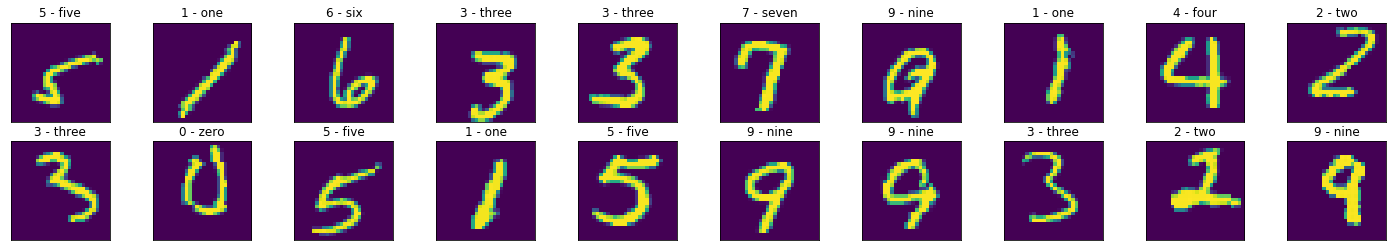

In [87]:
 # obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    images = images.cuda()


# plot the images in the batch, along with predicted labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    img = images.cpu()[idx]
    img = img * 0.5 + 0.5
    img = np.transpose(img, (1, 2, 0))
    img = img.reshape((28,28))
    plt.imshow(img)
    ax.set_title(test_data.classes[labels[idx].item()])


In [99]:
output_size = len(train_data.classes)
class LeNet5(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_size)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.pool(x)
        x = F.relu(x)
        x = x.view(x.shape[0], -1) ## Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        return x

        

In [100]:
lenet_model = LeNet5()
lenet_model

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [101]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("The models has {} trainable parameters.".format(count_parameters(lenet_model)))

The models has 44426 trainable parameters.


In [102]:
if train_on_gpu:
    print("Traning on GPU...")
    lenet_model.cuda()

Traning on GPU...


In [103]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters(), lr=0.001)

In [104]:
num_epochs = 20
train_losses = list()
valid_losses = []
valid_loss_min = np.inf

for e in range(num_epochs):
    
    train_loss = 0
    valid_loss = 0
    
    lenet_model.train()
    
    for img, label in train_loader:
        
        if train_on_gpu:
            img = img.cuda()
            label = label.cuda()
        optimizer.zero_grad()
        
        predicted_label = lenet_model(img)
        loss = criterion(predicted_label, label)
        loss.backward()
        optimizer.step()
        train_loss = train_loss + loss.item()
    
    for img, label in valid_loader:
        
        if train_on_gpu:
            img = img.cuda()
            label = label.cuda()
        predicted_label = lenet_model(img)
        loss = criterion(predicted_label, label)
        valid_loss = valid_loss + loss.item()
    
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print("Epoch: {} Train Loss: {} Valid Loss: {}".format(
        e+1, train_loss, valid_loss
    ))
    
    if valid_loss < valid_loss_min:
        print("Validation Loss Decreased From {} to {}".format(
            valid_loss_min, valid_loss
        ))
        
        valid_loss_min = valid_loss
        
        torch.save(lenet_model.state_dict(), "lenet5-best.pth")
        print("Saving Best Model")

Epoch: 1 Train Loss: 0.9120074936069583 Valid Loss: 0.7921230583748919
Validation Loss Decreased From inf to 0.7921230583748919
Saving Best Model
Epoch: 2 Train Loss: 0.7680429754893503 Valid Loss: 0.7543299792611853
Validation Loss Decreased From 0.7921230583748919 to 0.7543299792611853
Saving Best Model
Epoch: 3 Train Loss: 0.7488241101310575 Valid Loss: 0.7488834063740487
Validation Loss Decreased From 0.7543299792611853 to 0.7488834063740487
Saving Best Model
Epoch: 4 Train Loss: 0.7377855072671909 Valid Loss: 0.7645723065163227
Epoch: 5 Train Loss: 0.7321197962150048 Valid Loss: 0.7442001408719002
Validation Loss Decreased From 0.7488834063740487 to 0.7442001408719002
Saving Best Model
Epoch: 6 Train Loss: 0.7267730385418186 Valid Loss: 0.7251681799584246
Validation Loss Decreased From 0.7442001408719002 to 0.7251681799584246
Saving Best Model
Epoch: 7 Train Loss: 0.7251323762557236 Valid Loss: 0.7290248447593223
Epoch: 8 Train Loss: 0.7231177397301836 Valid Loss: 0.72521381936174

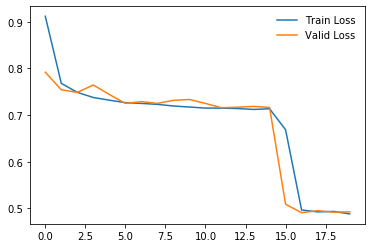

In [105]:
fig, axes = plt.subplots(nrows=1, ncols=1)
axes.plot(train_losses, label="Train Loss")
axes.plot(valid_losses, label="Valid Loss")
axes.legend(frameon=False)

In [106]:
## Testing the model.

num_epochs = 5
avg_accuracy = 0
total_accuracy = 0
test_loss = 0
accuracy = 0
lenet_model.eval()

for epoch in range(num_epochs):
    
    for img, label in test_loader:
        
        if train_on_gpu:
            img = img.cuda()
            label = label.cuda()
            
        predicted_label = lenet_model(img)
        loss = criterion(predicted_label, label)
        test_loss = test_loss + loss.item()
        
        top_probab, top_label = predicted_label.topk(1, dim=1)
        equals = top_label == label.view(*top_label.shape)
        
        accuracy = accuracy + torch.mean(equals.type(torch.FloatTensor))
    test_loss = test_loss/len(test_loader)
    accuracy = accuracy/len(test_loader)
    total_accuracy = total_accuracy + accuracy
    
    print("Epoch: {} Test Loss: {} Accuracy: {}".format(
        epoch+1, test_loss, accuracy
    ))

avg_accuracy = total_accuracy/(num_epochs) * 100

print("-----------------------\nAverage Accuracy: {:.3f}%-----------------------".format(avg_accuracy))

Epoch: 1 Test Loss: 0.49179880263896797 Accuracy: 0.8891773223876953
Epoch: 2 Test Loss: 0.4959549068338984 Accuracy: 0.8925172686576843
Epoch: 3 Test Loss: 0.4993725260222324 Accuracy: 0.8921286463737488
Epoch: 4 Test Loss: 0.4923199847928138 Accuracy: 0.8932256102561951
Epoch: 5 Test Loss: 0.4936605772796884 Accuracy: 0.8921309113502502
-----------------------
Average Accuracy: 89.184%-----------------------


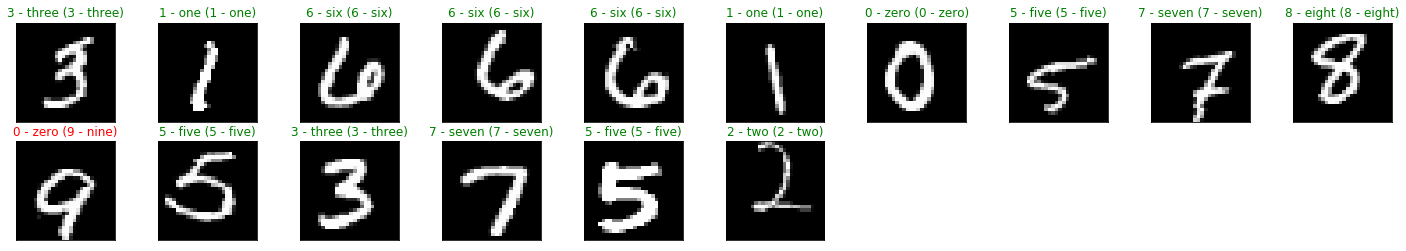

In [120]:
 # obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = lenet_model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())



# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    img = images.cpu()[idx]
    img = img * 0.5 + 0.5
    img = np.transpose(img, (1, 2, 0))
    img = img.reshape((28,28))
    plt.imshow(img, cmap="gray")
    ax.set_title("{} ({})".format(train_data.classes[preds[idx].item()], train_data.classes[labels[idx].item()]),
                 color=("green" if preds[idx]==labels[idx].item() else "red")) 
